# Multi-Scale Generalization on AudioMNIST with SITHCon

For a more detailed look, check out the following paper published in PMLR: [A deep convolutional neural network that is invariant to time rescaling](https://proceedings.mlr.press/v162/jacques22a.html)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/compmem/sithshow/blob/main/examples/audio_mnist.ipynb)

In [1]:
# TODO: optional magic to install the sith library 

In [2]:
from sithshow import model_utils, SITHCon_Classifier
from sithshow.dataset_utils import dataloader, random_split

import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import equinox as eqx

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import os

In [3]:
scales = ['0_40', '0_80', '1_00', '1_25', '2_50']
scaled_datasets = {}

for scale in scales:
    dir = os.path.abspath('') + f'/audio_mnist_data/scale_{scale}.npz'
    dat = np.load(dir)
    
    if scale != '1_00':
        scaled_datasets[scale] = dat['X'][:300], dat['Y'][:300]
    else:
        scaled_datasets[scale] = dat['X'], dat['Y']    

In [4]:
# We'll train on the normal scale
X, Y = scaled_datasets['1_00']
train_X, train_Y, test_X, test_Y = random_split(X, Y, train_proportion=.8)
train_X, train_Y = jnp.asarray(train_X), jnp.asarray(train_Y)

In [5]:
# Hyperparameters:
BATCH_SIZE=10
LEARNING_RATE=3e-3
STEPS=50
SEED=5678

iter_data = dataloader((X, Y), BATCH_SIZE)

sith_params = {'tau_min':.5, 
               'tau_max': 300,
               'n_taus': 50}

sithcon = SITHCon_Classifier(in_size=50, 
                             out_size=10,
                             sith_params=sith_params,
                             key=jrandom.PRNGKey(SEED))

sithcon = model_utils.cast_params_to_float32(sithcon)

In [6]:
optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(eqx.filter(sithcon, eqx.is_array))

@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_logits = jax.vmap(model)(x)

    return jnp.mean(optax.softmax_cross_entropy_with_integer_labels(pred_logits, y))

@eqx.filter_jit
def make_step(model, x, y, opt_state):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    return loss, model, opt_state

In [7]:
losses = []

for step, (x, y) in tqdm(zip(range(STEPS), iter_data)):
    loss, sithcon, opt_state = make_step(sithcon, x, y, opt_state)
    losses.append(loss.item())

50it [00:08,  5.60it/s]


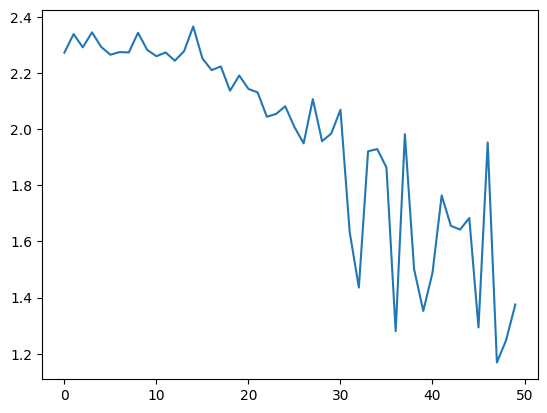

In [8]:
plt.plot(losses)

In [9]:
def get_avg_acc(X, Y):
    batch_model = jax.vmap(sithcon)
    total_acc = 0.0
    n_terms = 0

    iter_data = dataloader([X, Y], BATCH_SIZE, n_passes=1)

    for (x, y) in iter_data:
        pred = np.argmax(batch_model(x), 1)    
        acc = np.sum(pred == y) / len(x)

        total_acc += acc 
        n_terms += 1
        
    return total_acc / n_terms 

In [10]:
acc_scale_1 = get_avg_acc(test_X, test_Y).item()
print(acc_scale_1)

0.47000000000000003


In [11]:
sithcon = model_utils.increase_n_taus_sithcon(sithcon, 600) # TODO: currently a hack in the backend

In [12]:
scales = ['0_40', '0_80', '1_00', '1_25', '2_50']  
accs = []

for scale in scales:
    if scale == '1_00':
        accs.append(acc_scale_1)
    else:
        X, Y = scaled_datasets[scale]
        accs.append(get_avg_acc(X, Y).item())

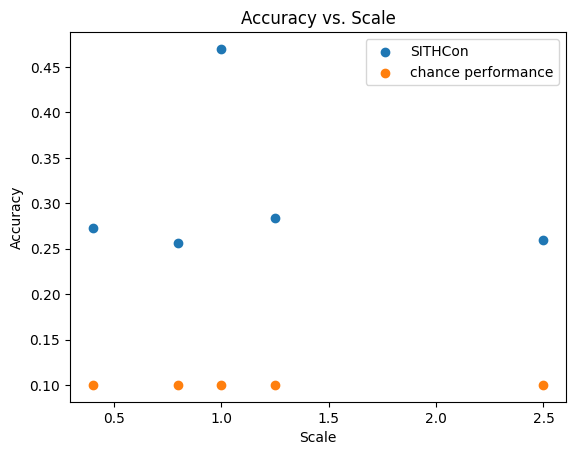

In [13]:
scale_factors = [.4, .8, 1., 1.25, 2.5]

plt.scatter(scale_factors, accs, label='SITHCon')
plt.scatter(scale_factors, np.ones(len(scale_factors))/10, label='chance performance')
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Scale')
plt.legend();